# Titanic Survival Prediction

In [1]:
# Import our standard libraries.
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

2024-03-21 19:25:56.093520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 19:25:56.093558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 19:25:56.137248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 19:25:56.235183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 19:25:57.251345: W tensorflow/compiler/tf2

## Load and prepare data

In [2]:
# https://www.kaggle.com/c/titanic/
df = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/test.csv')
print('Labeled data records:', len(df))
print('Kaggle test data records:', len(df_test))
print('First few records:')
display(df.head(10))

Labeled data records: 891
Kaggle test data records: 418
First few records:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Deal with missing values

In [3]:
# Check for missing (NaN) values.
print(df.isnull().sum())
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
# Replace missing values.
df['Age'].fillna(0, inplace=True)
df['Cabin'].fillna('Unknown', inplace=True)
df['Embarked'].fillna('Unknown', inplace=True)

df_test['Age'].fillna(0, inplace=True)
df_test['Cabin'].fillna('Unknown', inplace=True)
df_test['Fare'].fillna(0, inplace=True)

### Feature engineering

In [5]:
def get_title(x):
  return x['Name'].split(',')[1].split(' ')[1]

df['Title'] = df.apply(get_title, axis=1)
df_test['Title'] = df_test.apply(get_title, axis=1)

print(df['Title'].value_counts())

Title
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
the            1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: count, dtype: int64


### Train/dev split

In [6]:
df_train = df.sample(frac=0.85, random_state=3)
df_dev = df.drop(df_train.index)

print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(757, 13)
(134, 13)
(418, 12)


## Basic data analysis

Survived
0    472
1    285
Name: count, dtype: int64

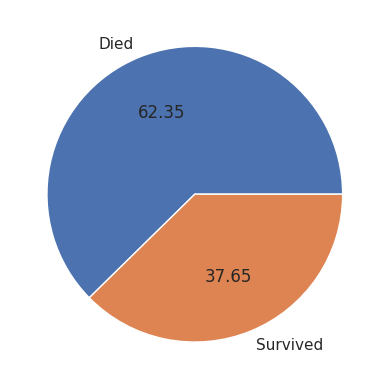

In [7]:
label_values = df_train['Survived'].value_counts()
display(label_values)
plt.pie(label_values, labels=['Died', 'Survived'], autopct='%.2f')
plt.show()

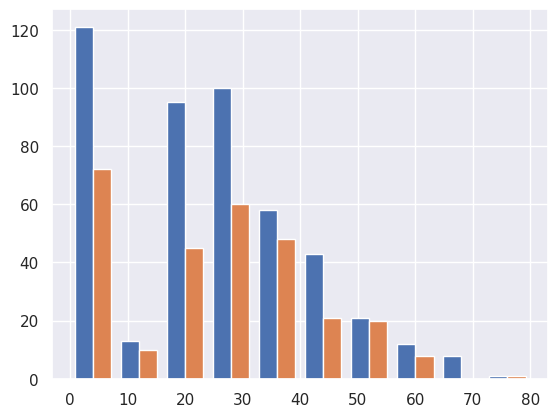

In [8]:
plt.hist([df_train['Age'][df_train['Survived']==0],
          df_train['Age'][df_train['Survived']==1]])
plt.show()

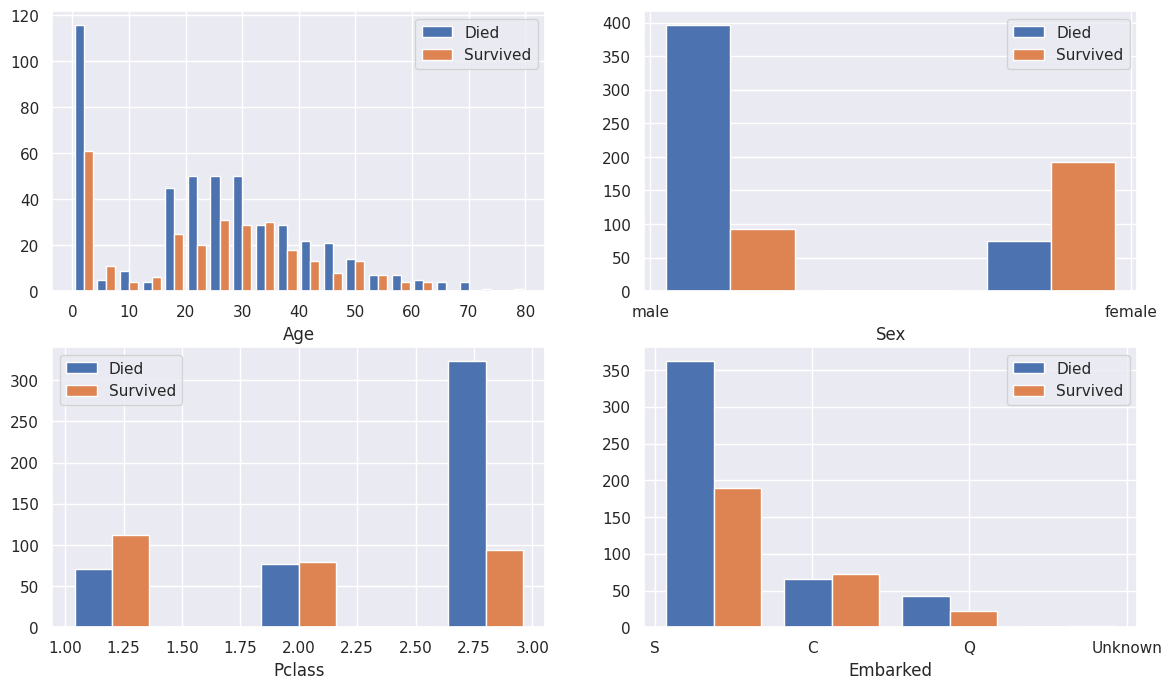

In [9]:
plt.figure(figsize=(14, 8))
plt.subplot(2,2,1)
plt.hist([df_train['Age'][df_train['Survived']==0],
          df_train['Age'][df_train['Survived']==1]],
          label=['Died', 'Survived'], bins=20)
plt.xlabel('Age')
plt.legend()
plt.subplot(2,2,2)
plt.hist([df_train['Sex'][df_train['Survived']==0],
          df_train['Sex'][df_train['Survived']==1]],
          label=['Died', 'Survived'],
          bins=3)
plt.xlabel('Sex')
plt.legend()
plt.subplot(2,2,3)
plt.hist([df_train['Pclass'][df_train['Survived']==0],
          df_train['Pclass'][df_train['Survived']==1]],
          label=['Died', 'Survived'],
          bins=5)
plt.xlabel('Pclass')
plt.legend()
plt.subplot(2,2,4)
plt.hist([df_train['Embarked'][df_train['Survived']==0],
          df_train['Embarked'][df_train['Survived']==1]],
          label=['Died', 'Survived'],
          bins=4)
plt.xlabel('Embarked')
plt.legend()
plt.show()

## Baselines

In [10]:
def majority_baseline(x):
  return 0  # corresponds to 'died'

def rule_baseline(x):
  if x['Sex'] == 'female':
    return 1  # 'survived'
  else:
    return 0  # 'died'

In [11]:
Y_train_pred_majority_baseline = df_train.apply(majority_baseline, axis=1)
Y_train_pred_rule_baseline = df_train.apply(rule_baseline, axis=1)
Y_dev_pred_majority_baseline = df_dev.apply(majority_baseline, axis=1)
Y_dev_pred_rule_baseline = df_dev.apply(rule_baseline, axis=1)

Y_train = df_train['Survived']
Y_dev = df_dev['Survived']

print('Majority baseline train accuracy: %.3f'
  %(np.sum(Y_train_pred_majority_baseline == Y_train) / len(Y_train)))
print('Majority baseline dev accuracy:   %.3f'
  %(np.sum(Y_dev_pred_majority_baseline == Y_dev) / len(Y_dev)))
print('Rule baseline train accuracy:     %.3f'
  %(np.sum(Y_train_pred_rule_baseline == Y_train) / len(Y_train)))
print('Rule baseline dev accuracy:       %.3f'
  %(np.sum(Y_dev_pred_rule_baseline == Y_dev) / len(Y_dev)))

Majority baseline train accuracy: 0.624
Majority baseline dev accuracy:   0.575
Rule baseline train accuracy:     0.778
Rule baseline dev accuracy:       0.836


## Model 1: Age as a Single Value

In [12]:
# Plot the loss at each epoch and show final numbers.
def show_history(history):
  plt.plot(history.history['loss'], color='black', label='train')
  plt.plot(history.history['val_loss'], color='red', label='dev')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print('final train acc: %.3f' %history.history['accuracy'][-1])
  print('final dev acc:   %.3f' %history.history['val_accuracy'][-1])

In [13]:
def build_model_sequential():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential(name='Titanic')
  model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
  model.add(tf.keras.layers.Dense(
      units=1, activation='sigmoid', name='Survived'))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
      loss='binary_crossentropy',
      metrics=['accuracy'])

  return model

### Functional API

In [14]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')

  survived = tf.keras.layers.Dense(
      units=1, activation='sigmoid', name='Survived')(age)

  model = tf.keras.Model(inputs=age,
                         outputs=survived,
                         name='Titanic')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss='binary_crossentropy',
      metrics=['accuracy'])

  return model

Model: "Titanic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Age (InputLayer)            [(None, 1)]               0         
                                                                 
 Survived (Dense)            (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-03-21 19:25:59.121254: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 19:25:59.269454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 19:25:59.269700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

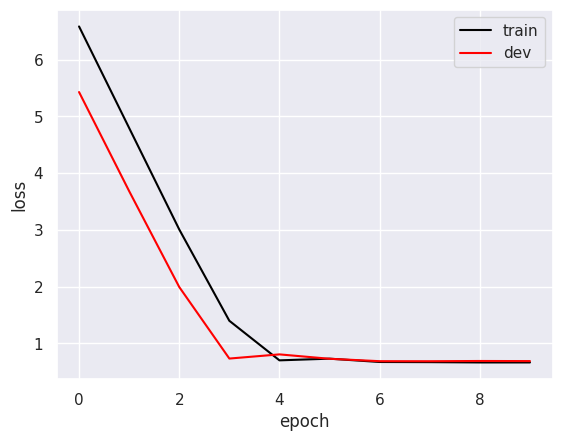

final train acc: 0.624
final dev acc:   0.575


In [15]:
model = build_model()
model.summary()

history = model.fit(
  x=df_train[['Age']],
  y=df_train[['Survived']],
  epochs=10,
  batch_size=64,
  validation_data=(
      df_dev[['Age']],
      df_dev[['Survived']]),
  verbose=0)

show_history(history)

## Model 2: Age in Buckets

### Tabular data processing

In [16]:
emb = np.array(df_train['Embarked'])[10:20]
print('Embarked:', emb)

emb_id = tf.keras.layers.StringLookup(
    vocabulary=['S', 'C', 'Q'], output_mode='one_hot')(emb)
print('Embarked ids:', emb_id)

Embarked: ['S' 'C' 'S' 'S' 'S' 'S' 'S' 'S' 'Q' 'S']
Embarked ids: tf.Tensor(
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]], shape=(10, 4), dtype=float32)


In [17]:
tf.keras.backend.clear_session()
age = np.array(df_train['Age'])[10:20]
print('Ages:', age)

age_bins = [0.1, 10, 40]
age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
print('Ages binned:', age_binned)

age_id = tf.keras.layers.IntegerLookup(vocabulary=np.arange(0, len(age_bins)+1),
                                       output_mode='one_hot')(age_binned)
print('Ages as one-hot vectors:', age_id)

Ages: [18.   0.  19.  33.   0.  19.  21.   1.  40.5 25. ]
Ages binned: tf.Tensor([2 0 2 2 0 2 2 1 3 2], shape=(10,), dtype=int64)
Ages as one-hot vectors: tf.Tensor(
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]], shape=(10, 5), dtype=float32)


In [18]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')

  age_bins = [0.1, 1, 5, 10, 20, 30, 40, 50, 60]
  age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
  age_id = tf.keras.layers.IntegerLookup(
      vocabulary=np.arange(0, len(age_bins)+1),
      output_mode='one_hot')(age_binned)

  survived = tf.keras.layers.Dense(
      units=1, activation='sigmoid', name='Survived')(age_id)

  model = tf.keras.Model(inputs=age,
                         outputs=survived,
                         name='Titanic')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss='binary_crossentropy',
      metrics=['accuracy'])

  return model

Model: "Titanic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Age (InputLayer)            [(None, 1)]               0         
                                                                 
 discretization (Discretiza  (None, 1)                 0         
 tion)                                                           
                                                                 
 integer_lookup (IntegerLoo  (None, 11)                0         
 kup)                                                            
                                                                 
 Survived (Dense)            (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


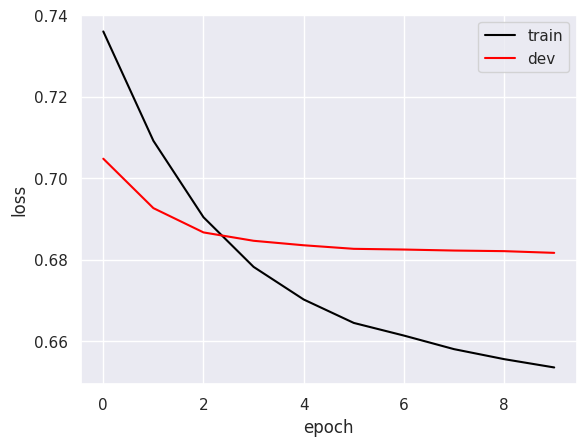

final train acc: 0.631
final dev acc:   0.582


In [19]:
model = build_model()
model.summary()

history = model.fit(
  x=df_train[['Age']],
  y=df_train[['Survived']],
  epochs=10,
  batch_size=64,
  validation_data=(
      df_dev[['Age']],
      df_dev[['Survived']]),
  verbose=0)

show_history(history)

## Model 3: Multiple Inputs

In [20]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')
  sex = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sex')
  pclass = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Pclass')
  emb = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Embarked')

  age_bins = [0.1, 1, 5, 10, 20, 30, 40, 50, 60]
  age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
  age_id = tf.keras.layers.IntegerLookup(
      vocabulary=np.arange(0, len(age_bins)+1),
      output_mode='one_hot')(age_binned)

  sex_id = tf.keras.layers.StringLookup(
      vocabulary=['male', 'female'], output_mode='one_hot')(sex)

  pclass_id = tf.keras.layers.IntegerLookup(
      vocabulary=[1, 2, 3], output_mode='one_hot')(pclass)

  emb_id = tf.keras.layers.StringLookup(
      vocabulary=['S', 'C', 'Q'], output_mode='one_hot')(emb)
  
  features = tf.keras.layers.Concatenate()([age_id, sex_id, pclass_id, emb_id])
  
  dense = tf.keras.layers.Dense(
      units=12, activation='tanh', name='hidden1')(features)
  
  survived = tf.keras.layers.Dense(
      units=1, activation='sigmoid', name='Survived')(dense)

  model = tf.keras.Model(inputs=[age, sex, pclass, emb],
                         outputs=survived,
                         name='Titanic')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
      loss='binary_crossentropy',
      metrics=['accuracy'])

  return model

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


None

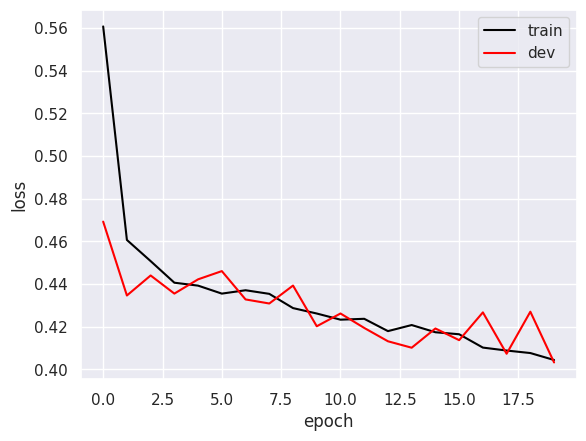

final train acc: 0.823
final dev acc:   0.836


In [21]:
model = build_model()
display(tf.keras.utils.plot_model(model))

history = model.fit(
  x={
      'Age': df_train[['Age']],
      'Sex': df_train[['Sex']],
      'Pclass': df_train[['Pclass']],
      'Embarked': df_train[['Embarked']],
    },
  y=df_train[['Survived']],
  epochs=20,
  batch_size=64,
  validation_data=(
      {
        'Age': df_dev[['Age']],
        'Sex': df_dev[['Sex']],
        'Pclass': df_dev[['Pclass']],
        'Embarked': df_dev[['Embarked']],
      },
      df_dev[['Survived']]),
  verbose=0)

show_history(history)

## Model 4: Using Embeddings

In [22]:
emb = np.array(df_train['Embarked'])[20:30]
print('Embarked:', emb)

emb_binned = tf.keras.layers.StringLookup(vocabulary=['S', 'C', 'Q'])(emb)
print('Embarked ids:', emb_binned)

emb_embed = tf.keras.layers.Embedding(
    input_dim=4, output_dim=4, input_length=1)(emb_binned)
print('Embarked embeddings:', emb_embed)

Embarked: ['S' 'S' 'S' 'S' 'Q' 'C' 'S' 'S' 'S' 'C']
Embarked ids: tf.Tensor([1 1 1 1 3 2 1 1 1 2], shape=(10,), dtype=int64)
Embarked embeddings: tf.Tensor(
[[-0.04604489  0.00745026 -0.0417609  -0.00227357]
 [-0.04604489  0.00745026 -0.0417609  -0.00227357]
 [-0.04604489  0.00745026 -0.0417609  -0.00227357]
 [-0.04604489  0.00745026 -0.0417609  -0.00227357]
 [-0.00589262 -0.02937138 -0.04812549 -0.02638693]
 [ 0.02444411 -0.01877494 -0.04027457  0.04787673]
 [-0.04604489  0.00745026 -0.0417609  -0.00227357]
 [-0.04604489  0.00745026 -0.0417609  -0.00227357]
 [-0.04604489  0.00745026 -0.0417609  -0.00227357]
 [ 0.02444411 -0.01877494 -0.04027457  0.04787673]], shape=(10, 4), dtype=float32)


In [23]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')
  sex = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sex')
  pclass = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Pclass')
  emb = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Embarked')

  embed_dim = 4

  age_bins = [0.1, 1, 5, 10, 20, 30, 40, 50, 60]
  age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
  sex_binned = tf.keras.layers.StringLookup(vocabulary=['male', 'female'])(sex)
  pclass_binned = tf.keras.layers.IntegerLookup(vocabulary=[1, 2, 3])(pclass)
  emb_binned = tf.keras.layers.StringLookup(vocabulary=['S', 'C', 'Q'])(emb)

  age_embed = tf.keras.layers.Embedding(
      input_dim=len(age_bins)+1, output_dim=embed_dim, input_length=1)(age_binned)
  sex_embed = tf.keras.layers.Embedding(
      input_dim=3, output_dim=embed_dim, input_length=1)(sex_binned)
  pclass_embed = tf.keras.layers.Embedding(
      input_dim=4, output_dim=embed_dim, input_length=1)(pclass_binned)
  emb_embed = tf.keras.layers.Embedding(
      input_dim=4, output_dim=embed_dim, input_length=1)(emb_binned)

  # features = tf.keras.layers.Concatenate()(
  #     [age_embed, sex_embed, pclass_embed, emb_embed])
  features = tf.keras.layers.Add()(
      [age_embed, sex_embed, pclass_embed, emb_embed])
  
  dense = tf.keras.layers.Dense(
      units=12, activation='tanh', name='hidden1')(features)

  survived = tf.keras.layers.Dense(
      units=1, activation='sigmoid', name='Survived')(dense)

  model = tf.keras.Model(inputs=[age, sex, pclass, emb],
                         outputs=survived,
                         name='Titanic')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
      loss='binary_crossentropy',
      metrics=['accuracy'])

  return model

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


None

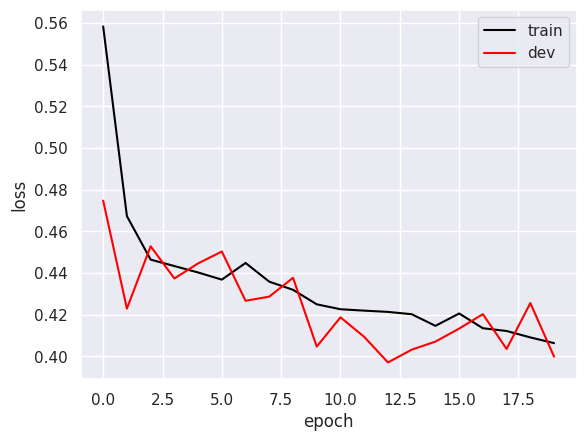

final train acc: 0.814
final dev acc:   0.836


In [24]:
model = build_model()
display(tf.keras.utils.plot_model(model))

history = model.fit(
  x={
      'Age': df_train[['Age']],
      'Sex': df_train[['Sex']],
      'Pclass': df_train[['Pclass']],
      'Embarked': df_train[['Embarked']],
    },
  y=df_train[['Survived']],
  epochs=20,
  batch_size=64,
  validation_data=(
      {
        'Age': df_dev[['Age']],
        'Sex': df_dev[['Sex']],
        'Pclass': df_dev[['Pclass']],
        'Embarked': df_dev[['Embarked']],
      },
      df_dev[['Survived']]),
  verbose=0)

show_history(history)

In [25]:
# Write to csv in the required format for kaggle submission
def output_csv(predictions):
  df_test['Survived'] = predictions.reshape(-1).round().astype(int)
  display(df_test.head(10))
  filename = 'titanic_predictions.csv'
  df_test.to_csv(
      filename,
      columns=['PassengerId', 'Survived'],
      index=False)
  print('Saved as:', filename)

In [26]:
test_preds = model.predict(
  x={
      'Age': df_test[['Age']],
      'Sex': df_test[['Sex']],
      'Pclass': df_test[['Pclass']],
      'Embarked': df_test[['Embarked']],
    }
)

output_csv(test_preds)

14/14 [==============================] - 0s 1ms/step


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr.,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs.,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Mr.,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mr.,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mrs.,0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,Unknown,S,Mr.,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,Unknown,Q,Miss.,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,Unknown,S,Mr.,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,Unknown,C,Mrs.,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,Unknown,S,Mr.,0


Saved as: titanic_predictions.csv


## Model 5: Multiple Outputs

In [27]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')
  sex = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sex')
  pclass = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Pclass')
  emb = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Embarked')

  embed_dim = 4

  age_bins = [0.1, 1, 5, 10, 20, 30, 40, 50, 60]
  age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
  sex_binned = tf.keras.layers.StringLookup(vocabulary=['male', 'female'])(sex)
  pclass_binned = tf.keras.layers.IntegerLookup(vocabulary=[1, 2, 3])(pclass)
  emb_binned = tf.keras.layers.StringLookup(vocabulary=['S', 'C', 'Q'])(emb)

  age_embed = tf.keras.layers.Embedding(
      input_dim=len(age_bins)+1, output_dim=embed_dim, input_length=1)(age_binned)
  sex_embed = tf.keras.layers.Embedding(
      input_dim=3, output_dim=embed_dim, input_length=1)(sex_binned)
  pclass_embed = tf.keras.layers.Embedding(
      input_dim=4, output_dim=embed_dim, input_length=1)(pclass_binned)
  emb_embed = tf.keras.layers.Embedding(
      input_dim=4, output_dim=embed_dim, input_length=1)(emb_binned)

  features = tf.keras.layers.Add()(
      [age_embed, sex_embed, pclass_embed, emb_embed])
  
  dense = tf.keras.layers.Dense(
      units=12, activation='tanh', name='hidden1')(features)

  survived = tf.keras.layers.Dense(
      units=1, activation='sigmoid', name='Survived')(dense)

  fare = tf.keras.layers.Dense(
      units=1, activation=None, name='Fare')(dense)

  model = tf.keras.Model(inputs=[age, sex, pclass, emb],
                         outputs=[survived, fare],
                         name='Titanic')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
      loss={'Survived': 'binary_crossentropy', 'Fare': 'mean_absolute_error'},
      loss_weights={'Survived': 9.0, 'Fare': 1.0},
      metrics={'Survived': 'accuracy', 'Fare': 'mean_absolute_error'})

  return model

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


None

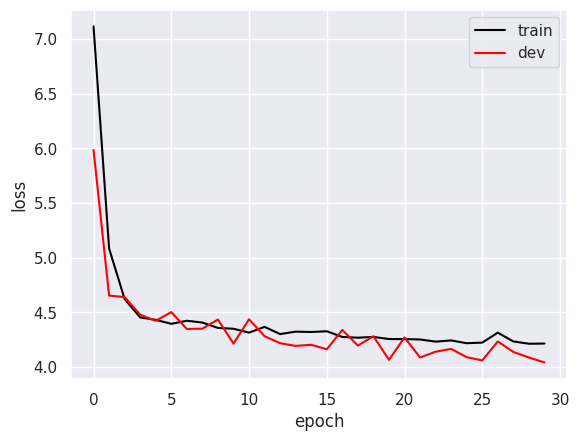

final train acc: 0.816
final dev acc:   0.836
final train mae: 0.420
final dev mae:   0.440


In [28]:
model = build_model()
display(tf.keras.utils.plot_model(model))

history = model.fit(
  x={
      'Age': df_train[['Age']],
      'Sex': df_train[['Sex']],
      'Pclass': df_train[['Pclass']],
      'Embarked': df_train[['Embarked']],
    },
  y={
      'Survived': df_train[['Survived']],
      'Fare': np.log(df_train[['Fare']] + 1)
    },
  epochs=30,
  batch_size=64,
  validation_data=(
      {
        'Age': df_dev[['Age']],
        'Sex': df_dev[['Sex']],
        'Pclass': df_dev[['Pclass']],
        'Embarked': df_dev[['Embarked']],
      },
      {
        'Survived': df_dev[['Survived']],
        'Fare': np.log(df_dev[['Fare']] + 1),
      }),
  verbose=0)

plt.plot(history.history['loss'], color='black', label='train')
plt.plot(history.history['val_loss'], color='red', label='dev')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
print('final train acc: %.3f' %history.history['Survived_accuracy'][-1])
print('final dev acc:   %.3f' %history.history['val_Survived_accuracy'][-1])
print('final train mae: %.3f' %history.history['Fare_mean_absolute_error'][-1])
print('final dev mae:   %.3f' %history.history['val_Fare_mean_absolute_error'][-1])